# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparatifs](#init)
* [2. Quelques essais de `Transformers` **SANS fine-tuning**](#TRANS)
    * [2.1 `distilbert-base-uncased-finetuned-sst-2-english` SANS fine-tuning](#TRANS_REF1)
    * [2.2 `cardiffnlp/twitter-roberta-base-sentiment` SANS fine-tuning](#TRANS_REF2)
* [3. Quelques essais de `Transformers` **AVEC fine-tuning**](#TRANSFT)
    * [3.1 `roberta-base` SANS fine-tuning](#TRANS_FT1)

---
---
# 1. Préparatifs pour de la classification avec des Transformers <a class="anchor" id="init"></a> [⇪](#menu)

In [1]:
!pip install transformers datasets
!pip install dagshub

In [2]:
import os
#os.chdir("/content/drive/MyDrive/Openclassrooms/OC_AI_O7")
os.getcwd()

'/home/jovyan/workspace/OC_AI_07'

In [3]:
import time
import pathlib 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

from dagshub import dagshub_logger, DAGsHubLogger
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, pipeline
from datasets import Dataset, load_dataset

import tensorflow as tf

# set random seed for reproductibility
random_seed = 0
np.random.seed(random_seed)

try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

2022-08-13 12:46:47.001962: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-08f56265-3e60-fe33-d84d-a721b8860dac)


### Chargeons quelques fonctions *maison* pour entrainer et évaluer les modèles, et initialisons un fichier pour enregistrer les scores
Ces fonctions ont été déportées dans le fichier classification_utils.py pour allèger le notebook

In [8]:
# Load classification helpers' functions & initialize a file to log the models' scores
from classification_utils import fit_model, get_scores, init_scores, find_best_threshold
init_scores("data/scores_NN_SelectTransformers.csv")

### Définissons les `fonctions et paramètres commun` à l'entrainement des différents modèles que l'on veut tester

In [9]:
# DagsHub 

def save_hyperparameters_to_dagshub(dlogger, model_name, archi_desc, layers, batch_size, sample_size, epochs=None):    
    dlogger.log_hyperparams(model_name=model_name)
    dlogger.log_hyperparams(archi_desc=archi_desc)
    dlogger.log_hyperparams(layers=layers)
    dlogger.log_hyperparams(batch_size=batch_size)
    dlogger.log_hyperparams(sample_size=sample_size)
    if epochs:
        dlogger.log_hyperparams(epochs=epochs)
    
def save_metrics_to_dagshub(dlogger, scores, best_threshold, history=None, step_num=1000, close=True):
    dlogger.log_metrics(scores, step_num=step_num)
    dlogger.log_metrics(best_threshold=best_threshold, step_num=step_num)
    if history:
        add_scores_to_dagshub(dlogger, history)

def get_layers_for_dagshub(model):
    
    layers_infos = []
    
    def search(layer):
        layer = dict(layer)
        
        nonlocal layers_infos
        
        if 'config' in layer:
    
            #if 'name' in layer['config']:
            #    print(" name:", layer['config']['name'])
            conf = {}
            if 'units' in layer['config']:
                conf["units"] = layer['config']['units']
            if 'output_dim' in layer['config']:
                conf['output_dim'] = layer['config']['output_dim']
            if 'rate' in layer['config']:
                conf['rate'] = layer['config']['rate']
            
            layers_infos.append((layer['class_name'], conf))
            
            if 'layer' in layer['config']:
                search(layer['config']['layer'])
        
    for layer in model.get_config()['layers']:
        search(layer)
        
    return layers_infos


def add_scores_to_dagshub(dlogger, history):
    for epoch, loss, accuracy, val_loss, val_accuracy in zip(
        history.epoch, 
        history.history['loss'], 
        history.history['accuracy'], 
        history.history['val_loss'], 
        history.history['val_accuracy']):
        scores = {
            'loss':loss, 
            'accuracy':accuracy, 
            'val_loss':val_loss, 
            'val_accuracy':val_accuracy
        }
        dlogger.log_metrics(scores, step_num=epoch) 

In [10]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [11]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.keras")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=3,
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )
    
    return [es]

### Chargeons le jeu de données et préparons un `échantillon de travail` représentatif

In [12]:
data_work = pd.read_csv(
    pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_1563108.csv'), 
    usecols=['target', 'text'],
    encoding='ISO-8859-1',
    #nrows=100000,
)
data_work.rename(columns={'text':'text', 'target':'label'}, inplace=True)
display(data_work.head(2), data_work.shape)

# Select samples
sample_size = 100000
data_work = data_work.groupby('label', group_keys=False).apply(lambda x: x.sample(sample_size//2, random_state=random_seed))
data_work.set_index('label', inplace=True, drop=True)
display(data_work.head(2), data_work.shape)

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...


(1452791, 2)

,text
label,
0,I dont have a background for my twitter stream...
0,I did many things but missed tweeting


(100000, 1)

In [13]:
dataset = Dataset.from_pandas(data_work)

In [14]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 100000
})

### Divisons le jeu de données en `Train`, `Valid` et `Test` sets

In [15]:
dsplit = dataset.train_test_split(test_size=0.1, seed=random_seed)
train_full_df = dsplit['train']
test_df = dsplit['test']

#dsplit = train_full_df.train_test_split(test_size=test_df.shape[0], seed=random_seed)
#train_df = dsplit['train']
#valid_df = dsplit['test']

print(f"train_full: {train_full_df.shape}, test: {test_df.shape}")

train_full: (90000, 2), test: (10000, 2)


---
---
# 2 - AutoModel & AutoTokenizer <a class="anchor" id="TRANS"></a> [⇪](#menu)

---
## 2.1 `distilbert-base-uncased-finetuned-sst-2-english` <a class="anchor" id="TRANS_REF1"></a> [⇪](#menu)

In [14]:
hug_model_name = "nlptown/bert-base-multilingual-uncased-sentiment" # 5 labels
hug_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest" # 3 labels mais fait pour
hug_model_name = "distilbert-base-uncased-finetuned-sst-2-english" # 2 labels
# finiteautomata/bertweet-base-sentiment-analysis ??
# "distilbert-base-uncased" --> fine-tuning

In [15]:
tf_model = TFAutoModelForSequenceClassification.from_pretrained(hug_model_name)
tokenizer = AutoTokenizer.from_pretrained(hug_model_name)

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [16]:
def preprocess_function(x):
    return tokenizer(x['text'], truncation=True, padding="max_length", max_length=65, return_tensors="tf")

def batch_inference(data, model, tokenizer_func, sample_size=None, step_size=1000, verbose=1):

    out = {'logits':tf.zeros([0, data.shape[1]])}
    # predictions_batches = []

    max_index = data.shape[0] if sample_size is None else min(sample_size, data.shape[0])
    print("max_index", max_index)
    for i in range(0, max_index, step_size):
        max_step = min(max_index - i, step_size)

        tokens = tokenizer_func(data[i:i+max_step])
        preds = model(tokens)
        # predictions_batches.append(preds['logits'])

        out['logits'] = tf.concat(axis=0, values = [tf.cast(out['logits'], tf.float32), preds['logits']])
        
        if verbose:
            print(i, i+max_step)

    #out2 = tf.concat(predictions_batches, axis=1)
    return out #{'logits':out2}

#### Quelques tests simples

In [17]:
test_txt = ["I hate this stuff", "I really love it"]
test_tokens = tokenizer(test_txt, truncation=True, padding="max_length", max_length=65, return_tensors="tf")

In [18]:
tf_outputs = tf_model(test_tokens)
tf_outputs

TFSequenceClassifierOutput([('logits',
                             <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
                             array([[ 4.3156366, -3.500103 ],
                                    [-4.3277135,  4.691517 ]], dtype=float32)>)])

In [19]:
tf_predictions = tf.nn.softmax(tf_outputs.logits, axis=-1)
tf_predictions

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[9.9959689e-01, 4.0317379e-04],
       [1.2104466e-04, 9.9987888e-01]], dtype=float32)>

In [20]:
y_preds_proba = tf_predictions.numpy()
y_preds_proba = [x[1] for x in y_preds_proba]
y_preds_proba

[0.0004031738, 0.9998789]

#### Définissons un logger DagsHub pour enregistrer notre essai

In [21]:
model_name = "Transformers_REF1"
archi_desc = f"Auto* RAW \"{hug_model_name}\""
X_test_ready = test_df['text']
y_test = test_df['label']

In [22]:
dagslogger = DAGsHubLogger()

In [23]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, hug_model_name, None, dataset.shape[0])

### Inference

#### Utilisons une fonction pour faire des inférences en batch (sinon ça ne passe pas en mémoire)

In [24]:
t0 = time.perf_counter()
tf_outputs = batch_inference(test_df, tf_model, preprocess_function, sample_size=20000, step_size=1000, verbose=1)
#tf_outputs
inf_time = time.perf_counter() - t0
print(f"Inference time: {inf_time:.2f}s")

max_index 20000
0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000
Inference time: 41.81s


#### Convertissons les scores en probabilité

In [25]:
tf_predictions = tf.nn.softmax(tf_outputs['logits'], axis=-1)

y_preds_proba = tf_predictions.numpy()
y_preds_proba = np.array([x[1] for x in y_preds_proba])
print(y_preds_proba)
print(len(y_preds_proba))

[1.1235430e-03 2.8306460e-03 9.9813831e-01 ... 3.3877930e-04 2.2621293e-02
 9.8465192e-01]
20000


#### Convertissons les probabilité en label (avec un threshold par défaut de 0.5)

In [26]:
y_preds = (y_preds_proba >= 0.5).astype("int")
y_preds

array([0, 0, 1, ..., 0, 0, 1])

### Evaluate

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Transformers_REF1 ------------------------------------------------------------------------------

             ROC_AUC : 0.7957
                  F1 : 0.6864
            ACCURACY : 0.7158
           PRECISION : 0.7696
              RECALL : 0.6194
   AVERAGE_PRECISION : 0.7958

       TRAINING-TIME : 0.0000
      INFERENCE-TIME : 41.8079

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.68      0.81      0.74      9961
Prediction = 1       0.77      0.62      0.69     10039

      accuracy                           0.72     20000
     macro avg       

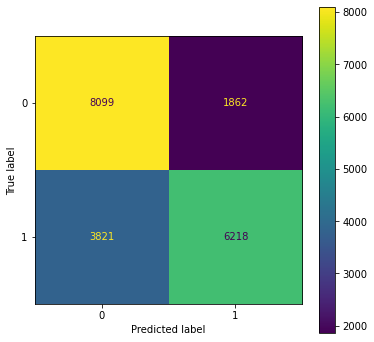

--- ROC AUC ---------------------------------------------------------------------------------------- 



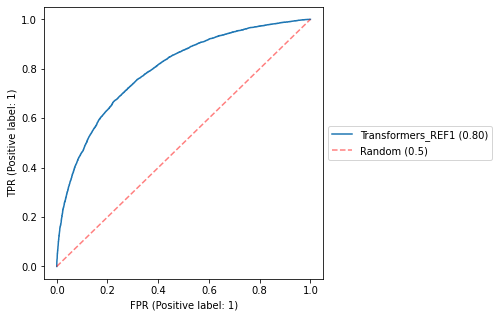

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



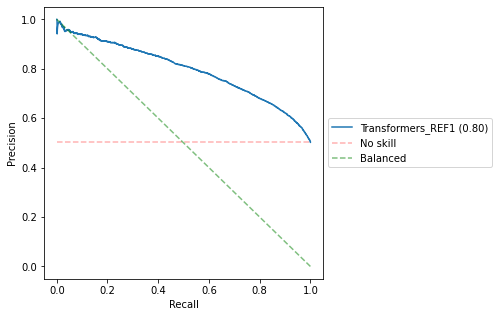

In [27]:
scores = get_scores(
    model_name,
    y_ref=y_test,
    y_pred=y_preds,
    y_pred_proba=y_preds_proba,
    threshold=0.5,
    training_time=0,
    inference_time=inf_time,
    show_roccurves=True,
    register=True,
)

#### Enregistrons les scores pour DagsHub

In [28]:
save_metrics_to_dagshub(dagslogger, scores, 0.5, None)
dagslogger.save() 
dagslogger.close()

---
## 2.2 `cardiffnlp/twitter-roberta-base-sentiment` <a class="anchor" id="TRANS_REF2"></a> [⇪](#menu)

In [46]:
hug_model_name = "cardiffnlp/twitter-roberta-base-sentiment"

In [30]:
tf_model = TFAutoModelForSequenceClassification.from_pretrained(hug_model_name)
tokenizer = AutoTokenizer.from_pretrained(hug_model_name)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [31]:
def preprocess_function(x):
    return tokenizer(x['text'], truncation=True, padding="max_length", max_length=65, return_tensors="tf")

def batch_inference(data, model, tokenizer_func, sample_size=None, step_size=1000, verbose=1):

    out = {'logits':tf.zeros([0, 3])}
    # predictions_batches = []

    max_index = data.shape[0] if sample_size is None else min(sample_size, data.shape[0])
    print("max_index", max_index)
    for i in range(0, max_index, step_size):
        max_step = min(max_index - i, step_size)

        tokens = tokenizer_func(data[i:i+max_step])
        preds = model(tokens)
        # predictions_batches.append(preds['logits'])

        out['logits'] = tf.concat(axis=0, values = [tf.cast(out['logits'], tf.float32), preds['logits']])
        
        if verbose:
            print(i, i+max_step)

    #out2 = tf.concat(predictions_batches, axis=1)
    return out #{'logits':out2}

#### Quelques tests simples

In [32]:
test_txt = ["I hate this stuff", "I really love it"]
test_tokens = tokenizer(test_txt, truncation=True, padding="max_length", max_length=65, return_tensors="tf")

In [33]:
tf_outputs = tf_model(test_tokens)
tf_outputs

TFSequenceClassifierOutput([('logits',
                             <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
                             array([[ 3.0689077 , -0.82197315, -2.2603767 ],
                                    [-1.9671813 , -0.71173984,  3.6045513 ]], dtype=float32)>)])

In [34]:
tf_predictions = tf.nn.softmax(tf_outputs.logits, axis=-1)
tf_predictions

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.9753482 , 0.01992377, 0.00472804],
       [0.00373974, 0.01312418, 0.9831361 ]], dtype=float32)>

In [35]:
y_preds_proba = tf_predictions.numpy()
y_preds_proba = [x[1] for x in y_preds_proba]
y_preds_proba

[0.019923773, 0.013124178]

#### Définissons un logger DagsHub pour enregistrer notre essai

In [36]:
model_name = "Transformers_REF2"
archi_desc = f"Auto* RAW \"{hug_model_name}\""
X_test_ready = test_df['text']
y_test = test_df['label']

In [37]:
dagslogger = DAGsHubLogger()

In [38]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, hug_model_name, None, dataset.shape[0])

### Inference

In [39]:
t0 = time.perf_counter()
tf_outputs = batch_inference(test_df, tf_model, preprocess_function, sample_size=20000, step_size=1000, verbose=1)
#tf_outputs
inf_time = time.perf_counter() - t0
print(f"Inference time: {inf_time:.2f}s")

max_index 20000
0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000
Inference time: 76.85s


#### Convertissons les scores en probabilité

In [40]:
tf_outputs['logits']

<tf.Tensor: shape=(20000, 3), dtype=float32, numpy=
array([[ 1.7810165 , -0.26327115, -1.5831052 ],
       [ 1.2228088 ,  0.35947222, -1.620912  ],
       [-2.3562136 , -0.7311932 ,  3.9054732 ],
       ...,
       [ 0.566668  ,  0.9709006 , -1.5116141 ],
       [-2.7649198 ,  1.2649193 ,  1.3402464 ],
       [ 0.16684118,  0.27269053, -0.2035625 ]], dtype=float32)>

In [41]:
tf_predictions = tf.nn.softmax(tf_outputs['logits'], axis=-1)

y_preds_proba = tf_predictions.numpy()
y_preds_proba = np.array([x[2] for x in y_preds_proba])
print(y_preds_proba)
print(len(y_preds_proba))

[0.02971689 0.03933122 0.988535   ... 0.04770524 0.51442254 0.24640559]
20000


#### Convertissons les probabilité en label (avec un threshold par défaut de 0.5)

In [42]:
y_preds = (y_preds_proba >= 0.5).astype("int")
y_preds

array([0, 0, 1, ..., 0, 1, 0])

### Evaluate

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Transformers_REF2 ------------------------------------------------------------------------------

             ROC_AUC : 0.8270
                  F1 : 0.6846
            ACCURACY : 0.7236
           PRECISION : 0.8013
              RECALL : 0.5976
   AVERAGE_PRECISION : 0.8203

       TRAINING-TIME : 0.0000
      INFERENCE-TIME : 76.8477

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.68      0.85      0.75      9961
Prediction = 1       0.80      0.60      0.68     10039

      accuracy                           0.72     20000
     macro avg       

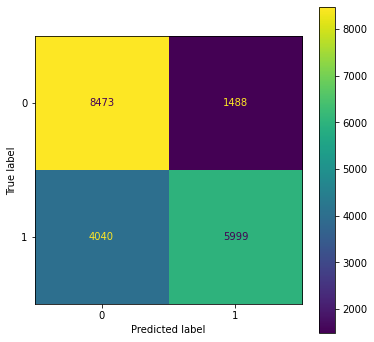

--- ROC AUC ---------------------------------------------------------------------------------------- 



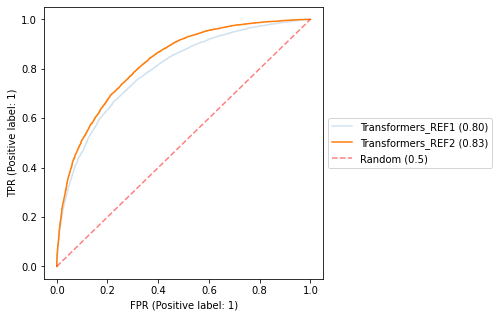

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



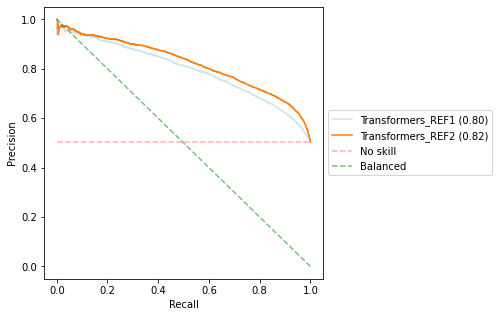

In [43]:
scores = get_scores(
    model_name,
    y_ref=y_test,
    y_pred=y_preds,
    y_pred_proba=y_preds_proba,
    threshold=0.5,
    training_time=0,
    inference_time=inf_time,
    show_roccurves=True,
    register=True,
)

#### Enregistrons les scores pour DagsHub

In [44]:
save_metrics_to_dagshub(dagslogger, scores, 0.5, None)
dagslogger.save() 
dagslogger.close()

### Compare

In [45]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Transformers_REF1,0.5,None,0.795734,0.795780,0.686351,0.71585,0.769554,0.619384,6218,8099,1862,3821,0,41.807902
1,Transformers_REF2,0.5,None,0.827015,0.820303,0.684583,0.72360,0.801256,0.597569,5999,8473,1488,4040,0,76.847669


---
---
# 3 - AutoModel & AutoTokenizer avec Fine-tuning <a class="anchor" id="TRANSFT"></a> [⇪](#menu)

---
## 3.1 `roberta-base` avec F.T. <a class="anchor" id="TRANS_FT1"></a> [⇪](#menu)

In [16]:
#hug_model_name = "distilbert-base-uncased-finetuned-sst-2-english"
hug_model_name = "roberta-base"

In [17]:
model_name = "Transformers_FT1"
archi_desc = f"Auto* Fine-tuning \"{hug_model_name}\""
X_test_ready = test_df['text']
y_test = test_df['label']
batch_size = 128
epochs = 25
learning_rate=1e-5

### Tokenize

In [18]:
tokenizer = AutoTokenizer.from_pretrained(hug_model_name)

In [19]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", max_length=65, truncation=True)#, return_tensors="tf")

tokenized_datasets = dsplit.map(tokenize_function, batched=True, )

  0%|          | 0/90 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [20]:
#sample_size = 20000
#train_size = int(sample_size*0.9)
#test_size = sample_size - train_size

train_ds = tokenized_datasets['train']#.shuffle(seed=random_seed).select(range(train_size))
test_ds = tokenized_datasets['test']#.shuffle(seed=random_seed).select(range(test_size))
print(f"train_ds: {train_ds.shape}, test_ds:{test_ds.shape}")

train_ds: (90000, 4), test_ds:(10000, 4)


#### Définissons un logger DagsHub pour enregistrer notre essai

In [41]:
dagslogger = DAGsHubLogger()

In [42]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, hug_model_name, batch_size, train_ds.shape[0]+test_ds.shape[0], epochs)

In [43]:
dagslogger.log_hyperparams(learning_rate=learning_rate)

### Prepare datasets

In [25]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = train_ds.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    #label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)

tf_validation_dataset = test_ds.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    #label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

### Prepare model

In [26]:
model = TFAutoModelForSequenceClassification.from_pretrained(hug_model_name, num_labels=1)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 591361    
 ficationHead)                                                   
                                                                 
Total params: 124,646,401
Trainable params: 124,646,401
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), # 2e-5 Value recommended by the Bert team
    loss="binary_crossentropy", #loss=tf.keras.losses.BinaryCrossentropy(), #from_logits=True),
    metrics=['accuracy'],# metrics=tf.metrics.SparseCategoricalAccuracy(),
)

In [29]:
# Sur 90K/10K lr:1e-5
t0 = time.perf_counter()
history = model.fit(
    tf_train_dataset, 
    validation_data=tf_validation_dataset, 
    epochs=epochs,
    batch_size=batch_size, 
    callbacks=init_callbacks(f"{model_name}"),
    verbose=1,
)
inf_time = time.perf_counter() - t0

Epoch 1/25
704/704 [==============================] - 1070s 1s/step - loss: 0.5164 - accuracy: 0.7744 - val_loss: 0.4349 - val_accuracy: 0.8411
Epoch 2/25
704/704 [==============================] - 1034s 1s/step - loss: 0.4530 - accuracy: 0.8192 - val_loss: 0.4138 - val_accuracy: 0.8618
Epoch 3/25
704/704 [==============================] - 1051s 1s/step - loss: 0.5379 - accuracy: 0.7477 - val_loss: 0.4166 - val_accuracy: 0.8633
Epoch 4/25
704/704 [==============================] - 1020s 1s/step - loss: 0.4464 - accuracy: 0.8281 - val_loss: 0.3803 - val_accuracy: 0.8640
Epoch 5/25
704/704 [==============================] - 1070s 2s/step - loss: 0.4987 - accuracy: 0.7840 - val_loss: 0.3882 - val_accuracy: 0.8448
Epoch 6/25
704/704 [==============================] - 1070s 2s/step - loss: 0.4257 - accuracy: 0.8330 - val_loss: 0.4279 - val_accuracy: 0.8654
Epoch 7/25
704/704 [==============================] - 1049s 1s/step - loss: 0.5027 - accuracy: 0.7793 - val_loss: 0.4153 - val_accuracy:

In [30]:
filepath = pathlib.Path("models", f"{model_name}_weight")
model.save_weights(filepath)
#filepath = pathlib.Path("models", f"{model_name}_model")
#model.save_pretrained(filepath)

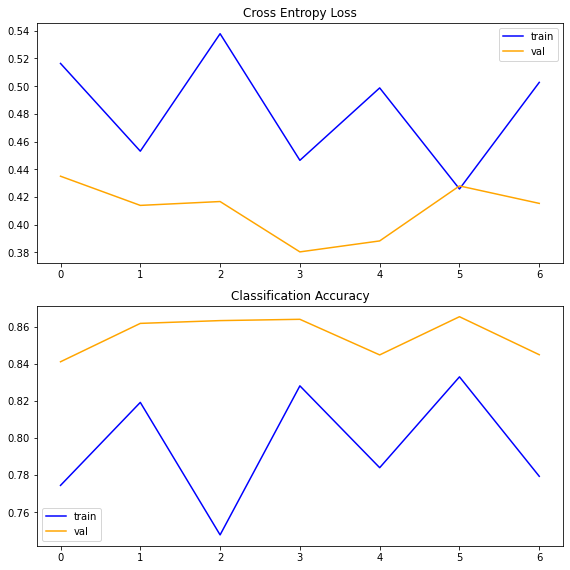

In [31]:
summarize_diagnostics(history)

### Inference

In [32]:
t0 = time.perf_counter()
tf_outputs = model.predict(tf_validation_dataset)
inf_time = time.perf_counter() - t0
print(f"Inference time: {inf_time:.2f}s")

79/79 [==============================] - 41s 483ms/step
Inference time: 40.78s


#### Convertissons les scores en probabilité

In [33]:
tf_outputs['logits'][:5]
print(len(tf_outputs['logits']))

y_preds_proba = tf_outputs['logits']

10000


#### Convertissons les probabilité en label (avec un threshold par défaut de 0.5)

In [34]:
y_preds = (y_preds_proba >= 0.5).astype("int")
# y_preds
print(len(y_preds))

10000


### Evaluate

In [38]:
training_time = 7363

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Transformers_FT1 -------------------------------------------------------------------------------

             ROC_AUC : 0.9380
                  F1 : 0.8616
            ACCURACY : 0.8640
           PRECISION : 0.8769
              RECALL : 0.8468
   AVERAGE_PRECISION : 0.9389

       TRAINING-TIME : 7363.0000
      INFERENCE-TIME : 40.7827

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.85      0.88      0.87      5001
Prediction = 1       0.88      0.85      0.86      4999

      accuracy                           0.86     10000
     macro avg    

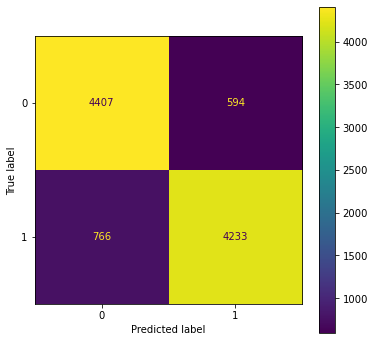

--- ROC AUC ---------------------------------------------------------------------------------------- 



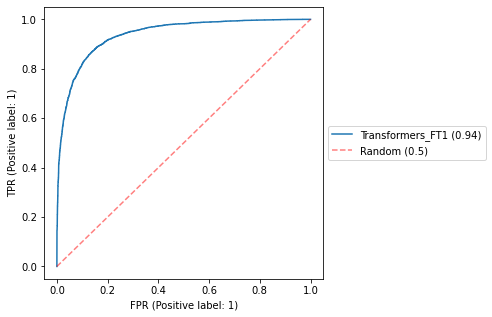

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



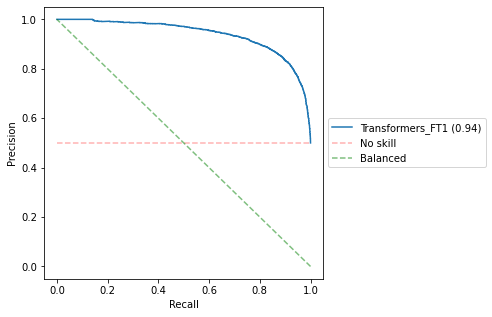

In [39]:
scores = get_scores(
    model_name,
    y_ref=test_ds['label'],
    y_pred=y_preds,
    y_pred_proba=y_preds_proba,
    threshold=0.5,
    training_time=training_time,
    inference_time=inf_time,
    show_roccurves=True,
    register=True,
)

#### Enregistrons les scores pour DagsHub

In [44]:
save_metrics_to_dagshub(dagslogger, scores, 0.5, None)
dagslogger.save() 
dagslogger.close()

### Compare

In [45]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Transformers_FT1,0.5,None,0.937993,0.938931,0.861592,0.864,0.876942,0.846769,4233,4407,594,766,7363,40.7827
